## 22AIE304 Deep Learning Labsheet 6

Name: Aniketh Vijesh

Roll No: AM.EN.U4AIE22009

In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

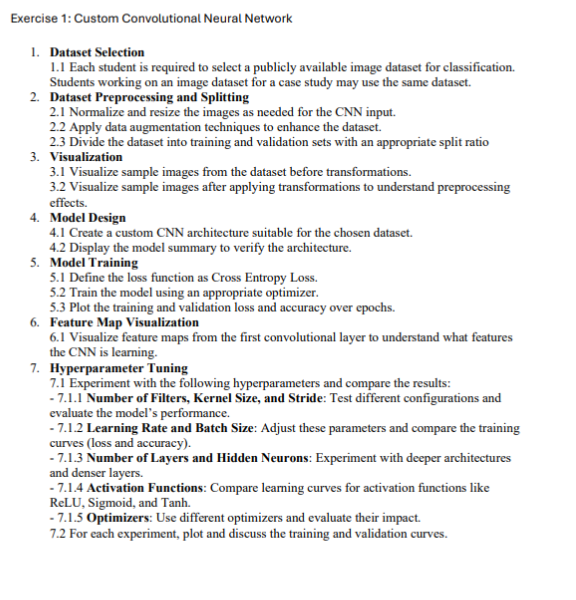

In [27]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [28]:
train_dataset = datasets.QMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.QMNIST(root='./data', train=False, transform=transform, download=True)

In [29]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [30]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

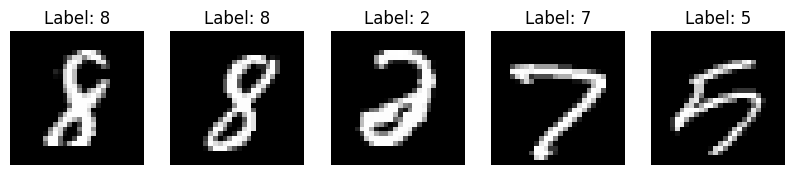

In [ ]:
def show_images(dataset, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        image, label = dataset[i]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

show_images(train_dataset)


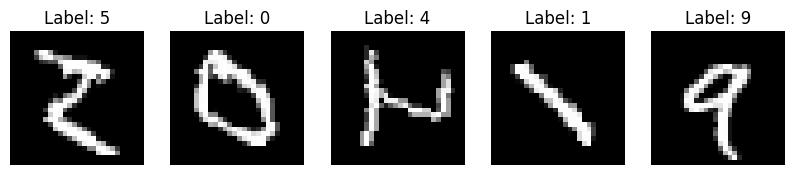

In [ ]:
aug_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmented_dataset = datasets.QMNIST(root='./data', train=True, transform=aug_transform)
show_images(augmented_dataset)


In [ ]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CustomCNN().to(device)
print(model)


CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / len(train_dataset))

        # Validation
        model.eval()
        val_running_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(val_correct / len(val_dataset))

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader)


Epoch [1/10], Train Loss: 0.1850, Val Loss: 0.0675, Train Acc: 0.9449, Val Acc: 0.9787
Epoch [2/10], Train Loss: 0.0505, Val Loss: 0.0645, Train Acc: 0.9844, Val Acc: 0.9805
Epoch [3/10], Train Loss: 0.0333, Val Loss: 0.0479, Train Acc: 0.9896, Val Acc: 0.9852
Epoch [4/10], Train Loss: 0.0267, Val Loss: 0.0391, Train Acc: 0.9915, Val Acc: 0.9869
Epoch [5/10], Train Loss: 0.0194, Val Loss: 0.0475, Train Acc: 0.9939, Val Acc: 0.9854
Epoch [6/10], Train Loss: 0.0135, Val Loss: 0.0455, Train Acc: 0.9960, Val Acc: 0.9877
Epoch [7/10], Train Loss: 0.0148, Val Loss: 0.0441, Train Acc: 0.9950, Val Acc: 0.9878
Epoch [8/10], Train Loss: 0.0096, Val Loss: 0.0498, Train Acc: 0.9967, Val Acc: 0.9870
Epoch [9/10], Train Loss: 0.0095, Val Loss: 0.0410, Train Acc: 0.9969, Val Acc: 0.9879
Epoch [10/10], Train Loss: 0.0061, Val Loss: 0.0443, Train Acc: 0.9980, Val Acc: 0.9888


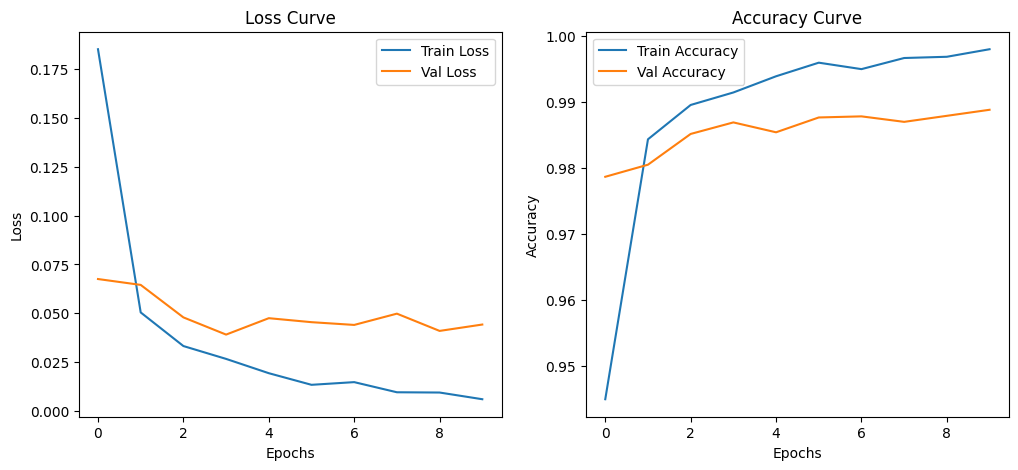

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()


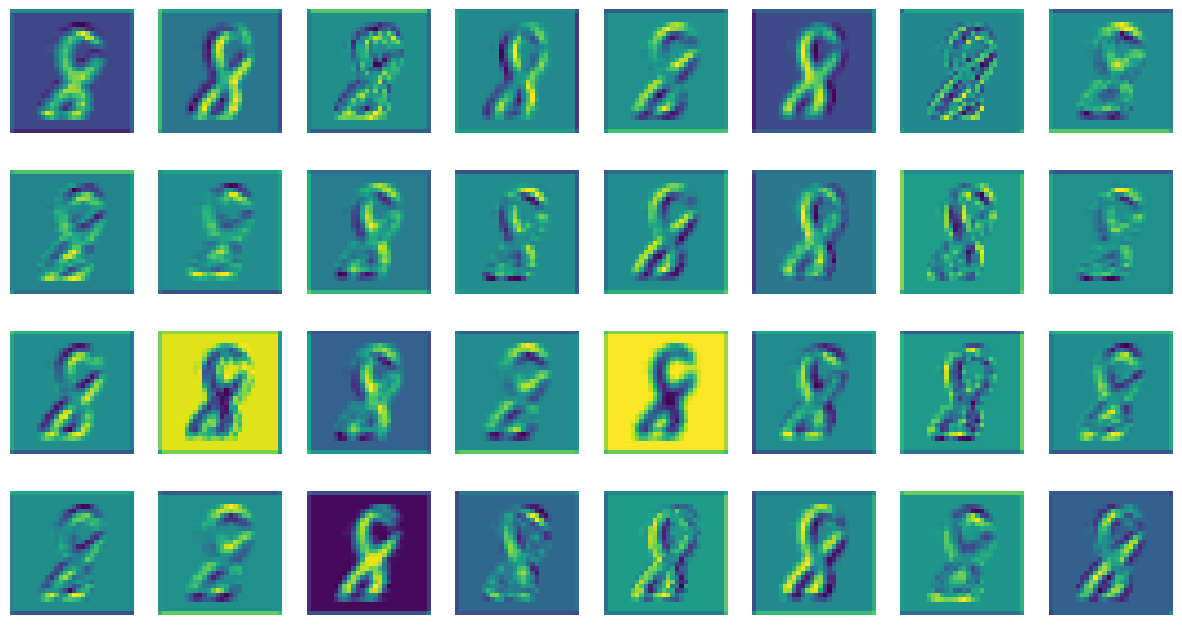

In [ ]:
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        feature_maps = model.conv1(image)
        feature_maps = feature_maps.cpu().squeeze().detach()

    fig, axs = plt.subplots(4, 8, figsize=(15, 8))
    for i, ax in enumerate(axs.flatten()):
        if i < feature_maps.size(0):
            ax.imshow(feature_maps[i], cmap='viridis')
        ax.axis('off')
    plt.show()

sample_image, _ = train_dataset[0]
visualize_feature_maps(model, sample_image)


## 7

Creating an adjustable network so thats its easier to fine tune and mess around with the hyperparams

In [ ]:
hyperparams = {
    "num_filters": [16, 32, 64],
    "kernel_size": [3],
    "stride": [1],
    "num_layers": [2, 3, 4],
    "hidden_neurons": [64, 128, 256],
    "activation_fn": [F.relu, F.sigmoid, F.tanh],
    "batch_size": [32, 64, 128],
    "learning_rate": [0.1, 0.01, 0.001],
    "optimizer": ["SGD", "Adam", "RMSprop"]
}

In [ ]:
# Custom CNN class
class CustomCNN(nn.Module):
    def __init__(self, num_filters, kernel_size, stride, num_layers, hidden_neurons, activation_fn):
        super(CustomCNN, self).__init__()
        layers = []
        in_channels = 1  # Assuming grayscale input
        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=kernel_size, stride=stride, padding=1))
            layers.append(nn.ReLU() if activation_fn == F.relu else nn.Tanh() if activation_fn == F.tanh else nn.Sigmoid())
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = num_filters
            num_filters *= 2
        self.conv_layers = nn.Sequential(*layers)
        self.fc1 = nn.Linear(in_channels * (28 // (2 ** num_layers)) ** 2, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def random_hyperparams(hyperparams):
    return {k: random.choice(v) for k, v in hyperparams.items()}

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    return train_losses, val_losses


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for i in range(5):  # Run 5 random experiments
    params = random_hyperparams(hyperparams)
    print(f"Experiment {i+1}: {params}")

    # Initialize model and optimizer
    model = CustomCNN(
        num_filters=params["num_filters"],
        kernel_size=params["kernel_size"],
        stride=params["stride"],
        num_layers=params["num_layers"],
        hidden_neurons=params["hidden_neurons"],
        activation_fn=params["activation_fn"]
    ).to(device)

    optimizer_class = torch.optim.SGD if params["optimizer"] == "SGD" else \
                      torch.optim.Adam if params["optimizer"] == "Adam" else \
                      torch.optim.RMSprop
    optimizer = optimizer_class(model.parameters(), lr=params["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)

    # Train model
    train_loss, val_loss = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10)

    # Store results
    results.append((params, train_loss, val_loss))

Experiment 1: {'num_filters': 64, 'kernel_size': 3, 'stride': 1, 'num_layers': 2, 'hidden_neurons': 128, 'activation_fn': <function sigmoid at 0x7cf6381a1c60>, 'batch_size': 128, 'learning_rate': 0.1, 'optimizer': 'Adam'}
Experiment 2: {'num_filters': 16, 'kernel_size': 3, 'stride': 1, 'num_layers': 2, 'hidden_neurons': 128, 'activation_fn': <function relu at 0x7cf6381a11b0>, 'batch_size': 64, 'learning_rate': 0.1, 'optimizer': 'RMSprop'}
Experiment 3: {'num_filters': 16, 'kernel_size': 3, 'stride': 1, 'num_layers': 2, 'hidden_neurons': 256, 'activation_fn': <function relu at 0x7cf6381a11b0>, 'batch_size': 128, 'learning_rate': 0.01, 'optimizer': 'SGD'}
Experiment 4: {'num_filters': 16, 'kernel_size': 3, 'stride': 1, 'num_layers': 3, 'hidden_neurons': 64, 'activation_fn': <function sigmoid at 0x7cf6381a1c60>, 'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'Adam'}
Experiment 5: {'num_filters': 64, 'kernel_size': 3, 'stride': 1, 'num_layers': 2, 'hidden_neurons': 64, 'activation_f

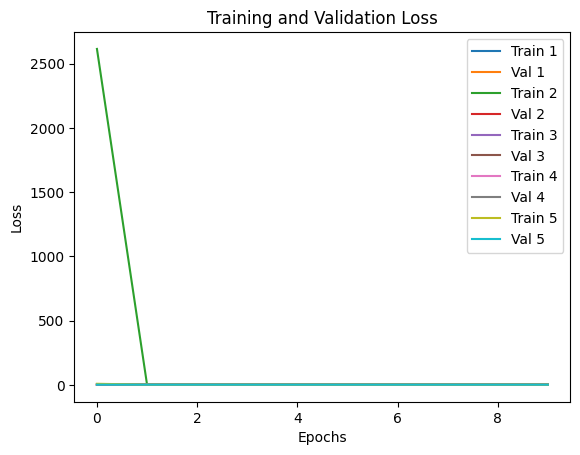

In [ ]:
for i, (params, train_loss, val_loss) in enumerate(results):
    plt.plot(train_loss, label=f"Train {i+1}")
    plt.plot(val_loss, label=f"Val {i+1}")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

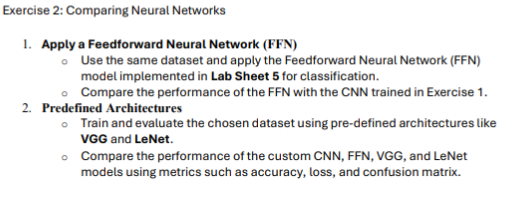

In [19]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

class FeedforwardNeuralNet(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10, num_hidden_layers=2, activation=nn.ReLU()):
        super(FeedforwardNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers - 1)])
        self.output = nn.Linear(hidden_size, output_size)
        self.activation = activation

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output(x)
        return x

# Train a model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_acc.append(correct / total)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc.append(correct / total)

    return train_acc, val_acc

# Function to evaluate models
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm


In [34]:
def get_predefined_model(arch):
    if arch == "VGG":
        model = models.vgg11(pretrained=False)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Adjust for 1-channel input
        model.classifier[6] = nn.Linear(4096, 10)  # Adjust output layer for 10 classes

        # Modify the feature extractor for smaller inputs
        model.features = nn.Sequential(
            *[layer for i, layer in enumerate(model.features) if i not in [16, 23]]  # Remove some pooling layers
        )
    elif arch == "LeNet":
        model = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
        )
    return model


In [37]:
models_to_train = {
    "FFN": FeedforwardNeuralNet(),
    "LeNet": get_predefined_model("LeNet")
}

Training FFN...
Training LeNet...


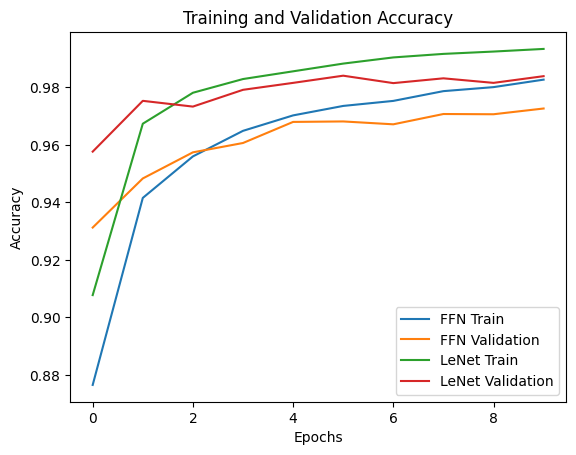

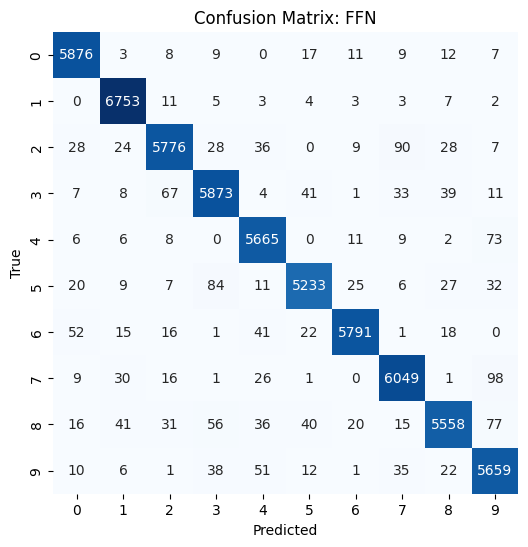

Test Accuracy for FFN: 0.97


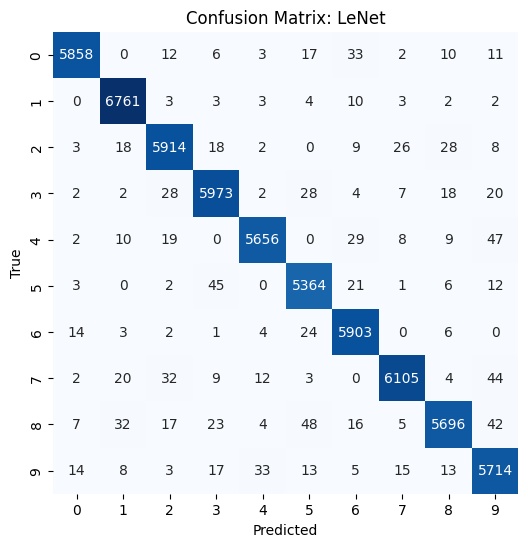

Test Accuracy for LeNet: 0.98


In [38]:
results = {}
for model_name, model in models_to_train.items():
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print(f"Training {model_name}...")
    train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)
    test_acc, cm = evaluate_model(model, test_loader)

    results[model_name] = {
        "train_acc": train_acc,
        "val_acc": val_acc,
        "test_acc": test_acc,
        "confusion_matrix": cm
    }

# Plot and compare
for model_name, result in results.items():
    plt.plot(result["train_acc"], label=f"{model_name} Train")
    plt.plot(result["val_acc"], label=f"{model_name} Validation")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Display confusion matrices
for model_name, result in results.items():
    plt.figure(figsize=(6, 6))
    sns.heatmap(result["confusion_matrix"], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    print(f"Test Accuracy for {model_name}: {result['test_acc']:.2f}")